In [272]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import glob
import matplotlib.pyplot as plt

### Draw

In [281]:
import cairocffi as cairo
from cairocffi import ImageSurface, Context
from cairocffi import FORMAT_ARGB32, FONT_SLANT_NORMAL, FONT_WEIGHT_NORMAL
from IPython.display import display_png, Image

def draw_gd(index):
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 256, 256)
    ctx = cairo.Context(surface)
    
    ctx.rectangle(0, 0, 1, 1)
    ctx.set_source_rgb(0.1, 0.977, 0.979)
    ctx.fill()
    ctx.set_source_rgb (0.1, 0.1, 0.1)

    for strokes in df.ix[index]['image']:
        for stroke_index in range(len(strokes)):
            if stroke_index % 2 == 0:
                # Move to the first point on the stroke
                ctx.move_to(strokes[stroke_index][0], strokes[stroke_index+1][0])
                # Draw the line
                for point_index in range(len(strokes[stroke_index])):
                    point_x = strokes[stroke_index][point_index]
                    point_y = strokes[stroke_index+1][point_index]
                    ctx.line_to(point_x, point_y)
                ctx.stroke()

    surface.write_to_png ("drawing.png")
    return Image('drawing.png')

### Unpack drawings

In [263]:
# Copyright 2017 Google Inc.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
# https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import struct
from struct import unpack


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

### Create the dataframe with the selected concepts

In [346]:
concepts = {
    'animals':[
        'cat',
        'dog',
        'fish',
        'whale',
        'dolphin',
        'spider',
        'crocodile',
        'elephant',
        'snake',
        'rabbit',
        'ant',
        'bear',
        'camel',
        'flamingo',
        'bat',
        'cow',
        'panda',
        'tiger',
        'kangaroo',
        'horse',
        'lion',
        'mosquito',
        'octopus',
        'monkey'
    ],
    'body':[
        'skull',
        'arm',
        'beard',
        'moustache',
        'mouth',
        'nose',
        'brain',
        'ear',
        'elbow',
        'eye',
        'face',
        'finger',
        'foot',
        'knee',
        'leg',
        'tooth',
        'toe'
    ],
    'sport':[
        'baseball',
        'baseball bat',
        'basketball',
        'bicycle',
        'boomerang',
        'canoe',
        'golf club',
        'hockey puck',
        'rollerskates',
        'soccer ball',
        'tennis racquet'
    ],
    'sea related':[
        
    ],
    'fantasy':[
        'mermaid',
        'dragon',
        'angel',
        
    ],
    'music':[
        'cello',
        'clarinet',
        'guitar',
        'harp',
        'piano',
        'saxophone',
        'violin'  
    ],
    'nature':[
        'rain',
        'tornado',
        'flower',
        'leaf',
        'ocean',
        'hurricane',
        'river'
    ],
    'food':[
        'aspargus',
        'banana',
        'apple',
        'lollipop',
        'onion',
        'strawberry',
        'watermelon',
        'wine bottle',
        'ice cream',
        'broccoli',
        'pizza',
        'potato'
    ],
    'clothes':[
        
    ],
    'tools':[
        
    ]
}

selected_concepts = [
    'cat',
    'face',
    'dog',
    'apple'
]

selected_concepts = concepts['sport']

In [347]:
len(set(concepts['animals']))

23

In [348]:
len(concepts['animals'])

23

In [349]:
drawings = []

for concept in selected_concepts:
    for drawing in unpack_drawings('binary/' + concept + '.bin'):
        drawing['concept'] = concept
        drawings.append(drawing)

df = pd.DataFrame(drawings)

### Clean the dataframe

In [350]:
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['countrycode'] = df['countrycode'].str.decode('utf-8')

In [351]:
df.head()

,concept,countrycode,image,key_id,recognized,timestamp,date
0,baseball,US,"[((138, 114, 88, 76, 55, 23, 9, 1, 2, 20, 37, ...",4736815032434688,1,1489804928,2017-03-18 02:42:08
1,baseball,US,"[((37, 37), (222, 222)), ((109, 104, 82, 49, 1...",5001461287092224,1,1490378866,2017-03-24 18:07:46
2,baseball,US,"[((6, 34, 62, 106, 157, 199, 210, 221, 246, 25...",5154170313113600,1,1485542999,2017-01-27 18:49:59
3,baseball,CZ,"[((54, 53, 76, 85, 105), (248, 237, 164, 125, ...",6739715099197440,0,1488369609,2017-03-01 12:00:09
4,baseball,US,"[((205, 205), (154, 154)), ((169, 145, 116, 90...",4820868905566208,1,1485355211,2017-01-25 14:40:11


### Percentage of unrecognized drawings by country

In [353]:
(df[df['concept'] == 'canoe']
 .groupby('countrycode')
 .filter(lambda x: len(x) > 1000)
 .groupby('countrycode')
 .apply(lambda x: x[x['recognized'] == 0]['recognized'].count() / len(x) * 100)
 .sort_values(ascending=False))

countrycode
SA    14.979757
KR     8.786611
TH     8.623418
HU     6.787330
GB     5.308057
PH     5.292259
SE     5.032120
DE     4.273769
CZ     4.218985
AU     3.968254
PL     3.843730
RO     3.636364
FI     3.517824
NL     3.366337
IT     3.208812
RU     3.057881
US     2.978889
CA     2.481542
FR     2.424942
BR     1.633987
dtype: float64

### What is the most unrecognized drawing?

In [354]:
(df.groupby('concept')
 .apply(lambda x: x[x['recognized'] == 0]['recognized'].count() / len(x) * 100)
 .sort_values(ascending=False))

concept
golf club         11.271126
hockey puck       10.790896
tennis racquet     9.480816
baseball bat       6.852491
baseball           6.600923
basketball         5.545881
boomerang          4.990819
soccer ball        4.874391
rollerskates       4.045186
canoe              3.772411
bicycle            3.151106
dtype: float64

### Which country produces the most detailed drawings?

In [257]:
# The more strokes a drawing has, the more detailed it is
(df.groupby('countrycode')
 .apply(lambda x: pd.Series([len(d) for d in x['image']]).mean())
 .sort_values(ascending=False)).head()

countrycode
BF    20.000000
AF    10.454545
BJ     9.000000
TJ     8.666667
MM     8.493671
dtype: float64

### Comparison between US and Korea

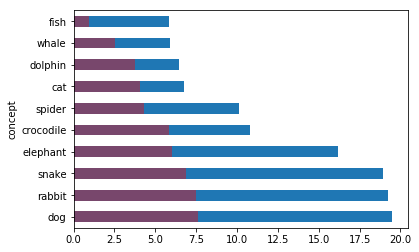

In [242]:
ax = (df[df['countrycode'] == 'US'].groupby('concept')
 .apply(lambda x: x[x['recognized'] == 0]['recognized'].count() / len(x) * 100)
 .sort_values(ascending=False)).plot(kind='barh')
(df[df['countrycode'] == 'KR'].groupby('concept')
 .apply(lambda x: x[x['recognized'] == 0]['recognized'].count() / len(x) * 100)
 .sort_values(ascending=False)).plot(kind='barh', ax=ax, alpha=0.4, color='red')

### Number of drawings by country

In [169]:
(df[df['concept'] == 'crocodile']
 .groupby('countrycode')
 .filter(lambda x: x['countrycode'].count() > 1000)['countrycode']
 .value_counts())

US    54278
GB     9145
CA     4665
DE     4276
AU     3318
RU     3138
CZ     2497
BR     2421
SE     2329
FI     2136
IT     2024
PL     1938
FR     1865
TH     1814
HU     1669
KR     1639
PH     1605
NL     1568
SA     1377
ID     1101
SK     1024
Name: countrycode, dtype: int64

### Average number of lines for the current drawing

In [224]:
# Average number of lines of the recognized drawings
df[df['recognized'] == 1]['image'].apply(lambda x: len(x)).mean()

5.8416910013637109

In [225]:
# Average number of lines of the unrecognized drawings
df[df['recognized'] == 0]['image'].apply(lambda x: len(x)).mean()

9.8970548897924253

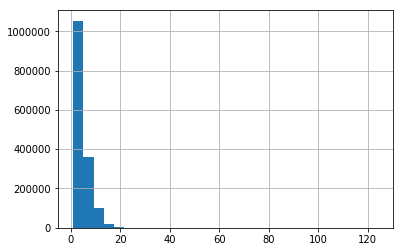

In [357]:
# Recognized
df[df['recognized'] == 1]['image'].apply(lambda x: len(x)).hist(bins=30)

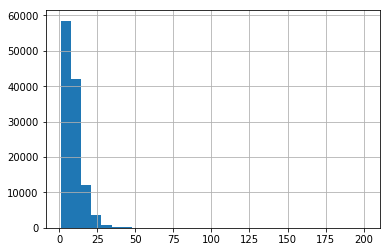

In [358]:
# Unrecognized
df[df['recognized'] == 0]['image'].apply(lambda x: len(x)).hist(bins=30)

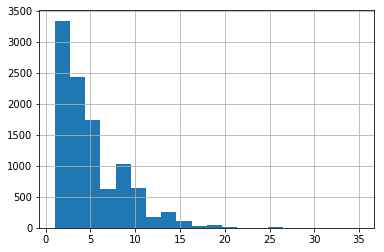

In [363]:
df[(df['recognized'] == 1) & (df['countrycode'] == 'JP')]['image'].apply(lambda x: len(x)).hist(bins=20)

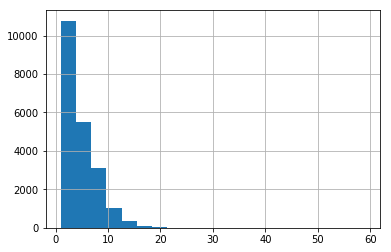

In [365]:
df[(df['recognized'] == 1) & (df['countrycode'] == 'FR')]['image'].apply(lambda x: len(x)).hist(bins=20)

In [370]:
df[(df['recognized'] == 1) & (df['countrycode'] == 'FR')].apply(lambda x: x['image'].sum()).plot(kind='scatter')

KeyError: ('image', 'occurred at index concept')

### Average complexity of the lines for the current drawing

In [311]:
# test only one concept otherwise it's too slow
concept = 'dog'

In [312]:
# Average complexity of the lines in the recognized drawings
(df[(df['recognized'] == 1) & (df['concept'] == concept)]
 ['image'].apply(lambda x: pd.Series([len(line[0]) for line in x]).mean())
 .mean())

12.166879725974832

In [313]:
# Average complexity of the lines in the unrecognized drawings
(df[(df['recognized'] == 0) & (df['concept'] == concept)]
 ['image'].apply(lambda x: pd.Series([len(line[0]) for line in x]).mean())
 .mean())

10.653770300636392

### Drawings with the lowest and highest number of lines

cat - IT


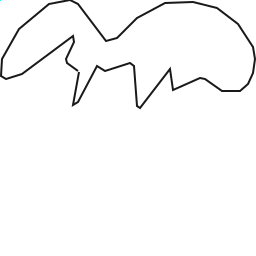

In [306]:
# Lowest
min_lines_index = df['image'].apply(lambda x: len(x)).idxmin()
print(df.ix[min_lines_index]['concept'], "-", df.ix[min_lines_index]['countrycode'])
draw_gd(min_lines_index)

crocodile - IT


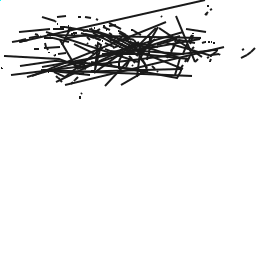

In [307]:
# Highest
max_lines_index = df['image'].apply(lambda x: len(x)).idxmax()
print(df.ix[max_lines_index]['concept'], "-", df.ix[min_lines_index]['countrycode'])
draw_gd(max_lines_index)

### Recognized drawings with the lowest and highest number of lines

In [329]:
concept = 'whale'

whale - NL


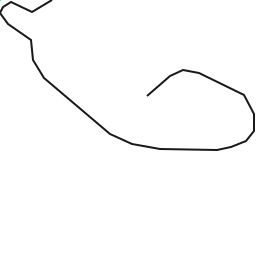

In [330]:
# Lowest
min_lines_index = (df[(df['recognized'] == 1) & (df['concept'] ==  concept)]
['image'].apply(lambda x: len(x)).idxmin())
print(df.ix[min_lines_index]['concept'], "-", df.ix[min_lines_index]['countrycode'])
draw_gd(min_lines_index)

whale - FR


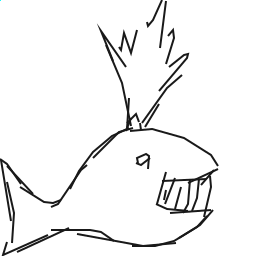

In [331]:
# Highest
min_lines_index = (df[(df['recognized'] == 1) & (df['concept'] == concept)]
['image'].apply(lambda x: len(x)).idxmax())
print(df.ix[min_lines_index]['concept'], "-", df.ix[min_lines_index]['countrycode'])
draw_gd(min_lines_index)

### Complexity of drawings

dog


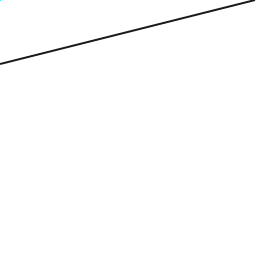

In [321]:
# Simplest
min_complex_index = (df[df['concept'] == concept]
 ['image'].apply(lambda x: pd.Series([len(line[0]) for line in x]).mean())
 .idxmin())
print(df.ix[min_complex_index]['concept'])
draw_gd(min_complex_index)

dog


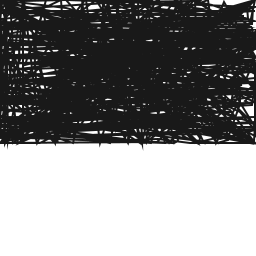

In [316]:
# most complex
max_complex_index = (df[df['concept'] == concept]
 ['image'].apply(lambda x: pd.Series([len(line[0]) for line in x]).mean())
 .idxmax())
print(df.ix[max_complex_index]['concept'])
draw_gd(max_complex_index)

### Complexity of recognized drawings

dog


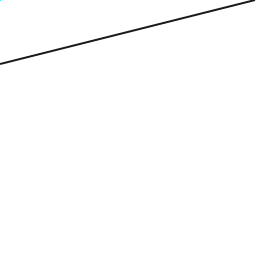

In [322]:
# Simplest
min_complex_index = (df[(df['recognized'] == 1) & (df['concept'] == concept)]
 ['image'].apply(lambda x: pd.Series([len(line[0]) for line in x]).mean())
 .idxmin())
print(df.ix[min_complex_index]['concept'])
draw_gd(min_complex_index)

dog


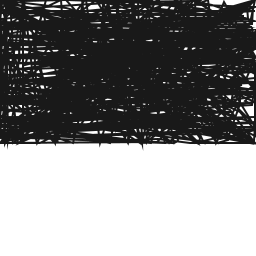

In [323]:
# Most complex
max_complex_index = (df[(df['recognized'] == 1) & (df['concept'] == concept)]
 ['image'].apply(lambda x: pd.Series([len(line[0]) for line in x]).mean())
 .idxmax())
print(df.ix[max_complex_index]['concept'])
draw_gd(max_complex_index)

### Evolution of the percentage of unrecognized drawings

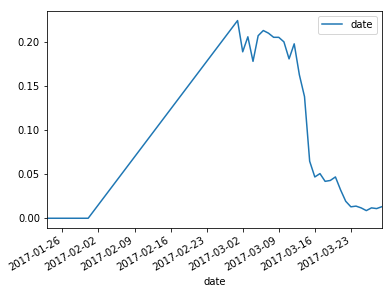

In [100]:
ax = (df.groupby(by=df['date'].dt.date)
      .apply(lambda x: x[x['recognized'] == 0].count() / len(x))
      .plot(y='date'))
fig = plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')